## Demanda neta

# Funciones y datos

In [1]:
# Importamos librerías
import os
import warnings
import numpy                           as np
import pandas                          as pd
import xarray                          as xr
from   matplotlib        import pyplot as plt
from   scipy             import stats
from   scipy             import optimize
from   scipy             import interpolate
from   matplotlib.ticker import StrMethodFormatter

In [2]:
# Funciones trigonométricas.
def sin(x) : return np.sin(np.radians(x))
def cos(x) : return np.cos(np.radians(x))
def tan(x) : return np.tan(np.radians(x))
def asin(x): return np.arcsin(x) * 180/np.pi
def acos(x): return np.arccos(x) * 180/np.pi
def atan(x): return np.arctan(x) * 180/np.pi

# Funciones para claves de regiones eléctricas

# Clave a número
def NUM_REGION(x):
    if   x == "BCA"  : y = 1
    elif x == "BCS"  : y = 2
    elif x == "CEN"  : y = 3
    elif x == "NES"  : y = 4
    elif x == "NOR"  : y = 5
    elif x == "NTE"  : y = 6
    elif x == "OCC"  : y = 7
    elif x == "ORI"  : y = 8
    elif x == "PEN"  : y = 9
    elif x == "PGE"  : y = 10
    elif x == "SCE"  : y = 11
    elif x == "SDGE" : y = 12
    elif x == "VEA"  : y = 13
    elif x == "COAST": y = 14
    elif x == "EAST" : y = 15
    elif x == "FWEST": y = 16
    elif x == "NORTH": y = 17
    elif x == "NCENT": y = 18
    elif x == "SOUTH": y = 19
    elif x == "SCENT": y = 20
    elif x == "WEST" : y = 21
    elif x == "LON"  : y = 22
    elif x == "LAT"  : y = 23
    elif x == "TOTAL": y = 24
    return y

# Número a clave
def NUM_REGION_r(x):
    if   x == 1 : y = "BCA"
    elif x == 2 : y = "BCS"
    elif x == 3 : y = "CEN"
    elif x == 4 : y = "NES"
    elif x == 5 : y = "NOR"
    elif x == 6 : y = "NTE"
    elif x == 7 : y = "OCC"
    elif x == 8 : y = "ORI"
    elif x == 9 : y = "PEN"
    elif x == 10: y = "PGE"
    elif x == 11: y = "SCE"
    elif x == 12: y = "SDGE"
    elif x == 13: y = "VEA"
    elif x == 14: y = "COAST"
    elif x == 15: y = "EAST"
    elif x == 16: y = "FWEST"
    elif x == 17: y = "NORTH"
    elif x == 18: y = "NCENT"
    elif x == 19: y = "SOUTH"
    elif x == 20: y = "SCENT"
    elif x == 21: y = "WEST"
    elif x == 22: y = "LON"
    elif x == 23: y = "LAT"
    elif x == 24: y = "TOTAL"
    return y

# Número a nombre
def NAME_REGION_r(x):
    if   x == 1 : y = "Baja California"
    elif x == 2 : y = "Baja California Sur"
    elif x == 3 : y = "Centro"
    elif x == 4 : y = "Noreste"
    elif x == 5 : y = "Noroeste"
    elif x == 6 : y = "Norte"
    elif x == 7 : y = "Occidente"
    elif x == 8 : y = "Oriente"
    elif x == 9 : y = "Peninsular"
    elif x == 10: y = "Pacific G&E"
    elif x == 11: y = "Southern Cal Edison"
    elif x == 12: y = "San Diego G&E"
    elif x == 13: y = "Valley Electric Assn"
    elif x == 14: y = "Coast"
    elif x == 15: y = "East"
    elif x == 16: y = "Far West"
    elif x == 17: y = "North"
    elif x == 18: y = "North Central"
    elif x == 19: y = "South"
    elif x == 20: y = "South Central"
    elif x == 21: y = "West"
    elif x == 22: y = "Longitudinal"
    elif x == 23: y = "Latitudinal"
    elif x == 24: y = "Total"
    return y

In [3]:
# Casos de orientación de sistemas fotovoltaico

# Casos a estudiar
cases = [ "south_no_track", "west_no_track", "east_no_track",
    "1_track", "2_track", "bifacial_vertical_west_main",
    "bifacial_vertical_east_main", "bifacial_vertical_west_back",
    "bifacial_vertical_east_back", "bifacial_south_back" ]
# Variables fotovoltaicas por caso
# Inclinación
track_tilt       =   [ f"{x}_Tilt"               for x in cases ]
# Azimuth
track_azimuth    =   [ f"{x}_Azimuth"            for x in cases ]
# Ángulo entre el panel y el sol, Angle of Incidence
track_AOI        =   [ f"{x}_Angle_of_Incidence" for x in cases ]
# Radiación incidente en el panel [W/m^2], Plane of Array Irradiace
track_POA        =   [ f"{x}_POA"                for x in cases ]
# Producción fotovoltaica por kilowatt de capacidad [W/kWp]
track_P_mp       = ( [ f"{x}_P_mp"               for x in cases ]
    + [ "bifacial_vertical_west_P_mp",
        "bifacial_vertical_east_P_mp",
        "bifacial_south_P_mp" ] )
# Producción para cada caso
prod_n           = track_P_mp[0:5] + track_P_mp[10:]
# Factor bifacial
P_bf = [ 1, 1, 1, 1, 1, 1, 1, 0.7, 0.7, 0.7 ]

prod_n_dist = [f"{x}_distributed" for x in prod_n]
prod_n_centr = [f"{x}_central" for x in prod_n]
prod_n_total = [f"{x}_total" for x in prod_n]
prod_n_i = prod_n + prod_n_dist + prod_n_centr + prod_n_total

In [30]:
# Datos de radiación

# Rutas de archivos
dir_r = "../results/"
ds_c = xr.open_dataset(f"{dir_r}full_disc_region_2022.nc")
ds_c["timezone_round"] = np.around(ds_c["timezone"]).astype(int)
for t in np.unique(ds_c["timezone_round"]): ds_c = xr.where(
    ds_c["timezone_round"] == t, ds_c.shift({"time": t}), ds_c )
ds_c

<xarray.Dataset> Size: 34MB
Dimensions:                                  (REGION: 24, time: 8760)
Coordinates:
  * REGION                                   (REGION) float64 192B 1.0 ... 24.0
  * time                                     (time) datetime64[ns] 70kB 2022-...
Data variables: (12/40)
    south_no_track_P_mp                      (REGION, time) float32 841kB 0.0...
    west_no_track_P_mp                       (REGION, time) float32 841kB 0.0...
    east_no_track_P_mp                       (REGION, time) float32 841kB 0.0...
    1_track_P_mp                             (REGION, time) float32 841kB 0.0...
    2_track_P_mp                             (REGION, time) float32 841kB 0.0...
    bifacial_vertical_west_P_mp              (REGION, time) float32 841kB 0.0...
    ...                                       ...
    1_track_P_mp_total                       (REGION, time) float32 841kB 0.0...
    2_track_P_mp_total                       (REGION, time) float32 841kB 0.0...
    bifacial_vertical_west_P_mp_total        (REGION, time) float32 841kB 0.0...
    bifacial_vertical_east_P_mp_total        (REGION, time) float32 841kB 0.0...
    bifacial_south_P_mp_total                (REGION, time) float32 841kB 0.0...
    timezone_round                           (REGION) int64 192B -8 -7 ... -8 -8

In [14]:
a = pd.read_csv(f"{dir_r}conus_points.csv")
b = a.groupby("REGION").count()["built_surface"]
b.loc[24] = b.mean()*0.65
b.loc[22] = b.loc[[1, 2, 4, 5, 6, 14, 19]].mean()
b.loc[23] = b.loc[[1, 2, 10, 11, 12, 13]].mean()
ds_c["count_built_surface"] = b.to_xarray()
ds_c[prod_n_dist] *= ds_c["count_built_surface"]
for i in range(len(prod_n_dist)):
    ds_c[prod_n_total[i]] = (("REGION", "time"), (ds_c[prod_n_dist[i]].values
        + ds_c[prod_n_centr[i]].values)/2)

In [6]:
b

REGION
1.0      1903.000000
2.0      1797.000000
3.0      1076.000000
4.0      7586.000000
5.0      6031.000000
6.0     10285.000000
7.0      7964.000000
8.0      8256.000000
9.0      3313.000000
10.0     4181.000000
11.0     4930.000000
12.0      277.000000
13.0      476.000000
14.0      708.000000
15.0     1048.000000
16.0     2869.000000
17.0     1602.000000
18.0     2068.000000
19.0     2040.000000
20.0     1427.000000
21.0     2338.000000
24.0     2233.988095
22.0     4335.714286
23.0     2260.666667
Name: built_surface, dtype: float64

In [29]:
ds_c["count_built_surface"]

<xarray.DataArray 'count_built_surface' (REGION: 24)> Size: 192B
array([1.90300000e+03, 1.79700000e+03, 1.07600000e+03, 7.58600000e+03,
       6.03100000e+03, 1.02850000e+04, 7.96400000e+03, 8.25600000e+03,
       3.31300000e+03, 4.18100000e+03, 4.93000000e+03, 2.77000000e+02,
       4.76000000e+02, 7.08000000e+02, 1.04800000e+03, 2.86900000e+03,
       1.60200000e+03, 2.06800000e+03, 2.04000000e+03, 1.42700000e+03,
       2.33800000e+03, 2.83585613e+09, 3.26343384e+09, 3.79869820e+10])
Coordinates:
  * REGION   (REGION) float64 192B 1.0 2.0 3.0 4.0 5.0 ... 21.0 22.0 23.0 24.0

In [40]:
r = 22
ds_c[prod_n_dist].sel(REGION=r).sum()

<xarray.Dataset> Size: 72B
Dimensions:                                  ()
Coordinates:
    REGION                                   float64 8B 22.0
Data variables:
    south_no_track_P_mp_distributed          float64 8B 1.647e+08
    west_no_track_P_mp_distributed           float64 8B 1.394e+08
    east_no_track_P_mp_distributed           float64 8B 1.409e+08
    1_track_P_mp_distributed                 float64 8B 1.85e+08
    2_track_P_mp_distributed                 float64 8B 2.089e+08
    bifacial_vertical_west_P_mp_distributed  float64 8B 1.116e+08
    bifacial_vertical_east_P_mp_distributed  float64 8B 1.122e+08
    bifacial_south_P_mp_distributed          float64 8B 1.753e+08

In [41]:
ds_c[prod_n_centr].sel(REGION=r).sum()

<xarray.Dataset> Size: 40B
Dimensions:                              ()
Coordinates:
    REGION                               float64 8B 22.0
Data variables:
    south_no_track_P_mp_central          float32 4B 1.823e+03
    west_no_track_P_mp_central           float32 4B 1.527e+03
    east_no_track_P_mp_central           float32 4B 1.54e+03
    1_track_P_mp_central                 float32 4B 2.044e+03
    2_track_P_mp_central                 float32 4B 2.327e+03
    bifacial_vertical_west_P_mp_central  float32 4B 1.216e+03
    bifacial_vertical_east_P_mp_central  float32 4B 1.221e+03
    bifacial_south_P_mp_central          float32 4B 1.932e+03

In [9]:
ds_c[prod_n_total].max()

<xarray.Dataset> Size: 32B
Dimensions:                            ()
Data variables:
    south_no_track_P_mp_total          float32 4B 1.985e+05
    west_no_track_P_mp_total           float32 4B 1.986e+05
    east_no_track_P_mp_total           float32 4B 2.01e+05
    1_track_P_mp_total                 float32 4B 2.047e+05
    2_track_P_mp_total                 float32 4B 2.066e+05
    bifacial_vertical_west_P_mp_total  float32 4B 1.491e+05
    bifacial_vertical_east_P_mp_total  float32 4B 1.536e+05
    bifacial_south_P_mp_total          float32 4B 2.034e+05

# Demanda

In [16]:
# Cargamos la demanda

# CENACE
# Ruta de la demanda para México
path_d = "../data/Demanda/"
path_f = f"{path_d}Mexico/Original/"
# Cargamos cada archivo
df_i = []
files = os.listdir(path_f)
files.sort()
for f in files:
    if f[0] != ".":
        df_0 = pd.read_csv(path_f + f, skiprows = 8,
            na_values = "               ---" )
        # Asignamos columnas
        df_0.columns = ["Sistema", "Area", "Hora", "Generacion (MWh)",
            "Importacion Total (MWh)", "Exportacion Total (MWh)",
            "Intercambio neto entre Gerencias (MWh)",
            "Estimacion de Demanda por Balance (MWh)"]
        df_0 = df_0[ ["Sistema", "Area", "Hora",
            "Estimacion de Demanda por Balance (MWh)"] ]
        df_0["Area"] = df_0["Area"].where(
            df_0["Area"]!="BCA", df_0["Sistema"] )
        df_0 = df_0.drop(columns = "Sistema")
        # Damos formato a la fecha
        df_0["Fecha"] = f[40:50]
        df_i.append(df_0)
df_cenace = pd.concat(df_i)
df_i = []
for c in df_cenace["Area"].unique():
    df_i.append(df_cenace[df_cenace["Area"] == c].copy())
for i in range(len(df_i)):
    df_i[i]["time"] = pd.date_range("2022-01-01", periods = 8760, freq = "h")
demanda = "Estimacion de Demanda por Balance (MWh)"
df_cenace = pd.concat(df_i).rename( columns =
    {demanda: "Demand", "Area": "REGION"} )
df_cenace["REGION"] = df_cenace["REGION"].apply(NUM_REGION)
df_cenace = df_cenace.set_index(["REGION", "time"]).drop(
    columns = ["Fecha", "Hora"]).sort_index()
# Interpolamos para rellenar el apagón en Yucatán
a = df_cenace.iloc[74214: 74220].values
df_cenace.iloc[74214: 74220] = interpolate.CubicSpline([0, 1, 4, 5],
    a[[0, 1, 4, 5]])([0, 1, 2, 3, 4, 5])

# ERCOT
path_ercot = f"{path_d}ERCOT/Native_Load_2022.xlsx"
df_ercot = pd.read_excel(path_ercot)
df_ercot["time"] = pd.date_range("2022-01-01", periods = 8760, freq = "h")
df_ercot = df_ercot.set_index("time").drop(columns = ["Hour Ending", "ERCOT"])
df_ercot = df_ercot.stack().reset_index(level = 1).rename(
    columns = {"level_1": "REGION", 0: "Demand"})
df_ercot["REGION"] = df_ercot["REGION"].apply(NUM_REGION)
df_ercot = df_ercot.set_index("REGION", append = True
    ).swaplevel("REGION", "time")
# Interpolamos para rellenar el apagón en Far West
a = df_ercot.iloc[65298:65298+8*6:8].values
df_ercot.iloc[65298:65298+8*6:8] = interpolate.CubicSpline([0, 1, 4, 5],
    a[[0, 1, 4, 5]])([0, 1, 2, 3, 4, 5])

#CAISO
path_caiso = f"{path_d}CAISO/historicalemshourlyload-2022.xlsx"
df_caiso = pd.read_excel(path_caiso)
df_caiso["time"] = pd.date_range("2022-01-01", periods = 8760, freq = "h")
df_caiso = df_caiso.set_index("time").drop(columns = ["Date", "HR", "CAISO"])
df_caiso = df_caiso.stack().reset_index(level = 1).rename(
    columns = {"level_1": "REGION", 0: "Demand"})
df_caiso["REGION"] = df_caiso["REGION"].apply(NUM_REGION)
df_caiso = df_caiso.set_index("REGION", append = True
    ).swaplevel("REGION", "time")

# Unimos las regiones
ds_d = pd.concat( [df_ercot, df_caiso, df_cenace]
    ).sort_index().to_xarray()

ds_d["timezone_round"] = ds_c["timezone_round"]
# Datos agregados para generación
# Agrupamiento longitudinal
ds_i = ds_d.where(ds_d["REGION"].isin([1, 2, 4, 5, 6, 14, 19]))
for t in np.unique(ds_i["timezone_round"]): 
    if not np.isnan(t): ds_i = xr.where(
        ds_i["timezone_round"] == t, ds_i.shift({"time": -(int(t)+8)}), ds_i )
ds_i["REGION"] = ds_i["REGION"].where(ds_i["REGION"] == 22, 22)
ds_d_2 = ds_i.groupby("REGION").sum()
# Agrupamiento latitudinal
ds_i = ds_d.where(ds_d["REGION"].isin([1, 2, 10, 11, 12, 13]))
for t in np.unique(ds_i["timezone_round"]): 
    if not np.isnan(t): ds_i = xr.where(
        ds_i["timezone_round"] == t, ds_i.shift({"time": -(int(t)+8)}), ds_i )
ds_i["REGION"] = ds_i["REGION"].where(ds_i["REGION"] == 23, 23)
ds_d_3 = ds_i.groupby("REGION").sum()
# Agrupamiento total
ds_i = ds_d.copy()
for t in np.unique(ds_i["timezone_round"]): 
    if not np.isnan(t): ds_i = xr.where(
        ds_i["timezone_round"] == t, ds_i.shift({"time": -(int(t)+8)}), ds_i )
ds_i["REGION"] = ds_i["REGION"].where(ds_i["REGION"] == 24, 24)
ds_d_4 = ds_i.groupby("REGION").sum()
ds_d = xr.concat([ds_d, ds_d_2, ds_d_3, ds_d_4], "REGION")
ds_d["REGION"] = ds_d["REGION"].astype(int)

ds_d["hour"] = ds_d["time"].dt.hour.copy()
ds_d["dayofyear"] = ds_d["time"].dt.dayofyear.copy()
ds_c["hour"] = ds_c["time"].dt.hour.copy()
ds_c["dayofyear"] = ds_c["time"].dt.dayofyear.copy()

# Unimos demanda y producción
ds_c["Demand"] = ds_d["Demand"]

In [12]:
# Suprimimos las alertas de scipy
with warnings.catch_warnings(action="ignore"):

    # Minimun capacity to reach zero net demand during duck's belly
    prod_n_cap = [f"{x}_capacity" for x in prod_n_i]
    # Función que determina la demanda mínima en términos de la capacidad
    def demand(x, v, c):
        return (ds_c["Demand"] - ds_c[v] * x).sel({"REGION": c}).pipe(np.min)
    # Encontramos la capacidad que ocasiona una demanda nula
    for i, v in enumerate(prod_n_i):
        n = []
        x0 = 5e7
        for c in ds_c["REGION"].values: n.append(optimize.fsolve(
            demand, x0 = x0, args = (v, c))[0] / 1000)
        ds_c[prod_n_cap[i]] = ("REGION", n)
    ds_c["min_capacity"] = ( "REGION",
        ds_c[prod_n_cap].to_dataframe().min(axis = 1).values )

    # Net demand with capacity that produces zero demand
    # Demanda neta [MW]
    names_dn = ["South-facing", "West-facing", "East-facing",
        "1 axis tracking", "2 axis tracking",
        "Bifacial, vertical, west-facing", "Bifacial, vertical, east-facing",
        "Bifacial, south facing", ]
    names_dn_t = ( names_dn + [f"{x}_distributed" for x in names_dn]
        + [f"{x}_central" for x in names_dn]
        + [f"{x}_total" for x in names_dn] )
    track_net_demand = [ f"{x}_net_demand"  for x in names_dn_t ]
    ds_c[track_net_demand] = ( ds_c["Demand"]
        - ds_c[prod_n_i] * ds_c[prod_n_cap].rename(
        dict(zip(prod_n_cap, prod_n_i))) * 1000 )
    # Net demand with same capacity for all cases
    prod_dn_min = [f"{x}_min" for x in track_net_demand]
    ds_c[prod_dn_min] = ( ds_c["Demand"]
        - ds_c[prod_n_i] * ds_c["min_capacity"] * 1000 )
    # Energy produced
    ener = [ f"{x}_energy" for x in prod_n_i ]
    ds_c[ener] = ( ds_c[prod_n_i]
        * ds_c[prod_n_cap].rename(dict(zip(prod_n_cap, prod_n_i))) / 1e3
        ).sum("time")
    # Demand ramp
    track_net_demand_dt = [ f"{x}_dt" for x in track_net_demand ]
    ds_c[track_net_demand_dt] = ( ds_c[track_net_demand]
        - ds_c[track_net_demand].shift(time = 1) )
    ds_c["Demand_dt"] = ( ds_c["Demand"]
        - ds_c["Demand"].shift(time = 1) )
    # Capacity factor
    cap_f = [ f"{x}_capacity_factor" for x in prod_n_i ]
    ds_c[cap_f] = ( 100 * 1000 * ds_c[ener] / ( 24 * 365
        * ds_c[prod_n_cap].rename(dict(zip(prod_n_cap, ener))) ) )

    # Demanda máxima
    track_net_demand_max = [f"{x}_max_demand" for x in ["No_PV"] + names_dn_t]
    ds_c[track_net_demand_max] = ds_c[ ["Demand"] + track_net_demand
        ].pipe(np.abs).max("time")
    # Demanda mínima
    track_net_demand_min = [f"{x}_min_demand" for x in ["No_PV"] + names_dn_t]
    ds_c[track_net_demand_min] = ds_c[ ["Demand"] + track_net_demand
        ].pipe(np.abs).min("time")
    # Rampa máxima
    track_net_demand_dt_max = [f"{x}_max_ramp" for x in ["No_PV"] + names_dn_t]
    ds_c[track_net_demand_dt_max] = ds_c[ ["Demand"] + track_net_demand_dt
        ].pipe(np.abs).max("time")
    # Rampa mínima
    track_net_demand_dt_min = [f"{x}_min_ramp" for x in ["No_PV"] + names_dn_t]
    ds_c[track_net_demand_dt_min] = ds_c[ ["Demand"] + track_net_demand_dt
        ].pipe(np.abs).min("time")

    # Producción total
    prod_n_sum = [f"{x}_sum" for x in prod_n]
    prod_n_dist_sum = [f"{x}_sum" for x in prod_n_dist]
    prod_n_centr_sum = [f"{x}_sum" for x in prod_n_centr]
    prod_n_total_sum = [f"{x}_sum" for x in prod_n_total]
    prod_n_sum_i = ( prod_n_sum + prod_n_dist_sum
        + prod_n_centr_sum + prod_n_total_sum )
    ds_c[prod_n_sum_i] = (
        ds_c[prod_n + prod_n_dist + prod_n_centr + prod_n_total]).sum("time")

n = (ds_c[track_net_demand_min[1:]]>1e-10).to_array().sum().values+0
print(f"Number of failed points: {n}")

Number of failed points: 0


In [13]:
# Determinamos la configuración ideal
indicators = [ "Photovoltaic generation per GWp", "Maximum capacity",
    "Photovoltaic generation", "Capacity factor",
    "Maximum load", "Maximum load ramp" ]
results = [ prod_n_sum_i[-8:], prod_n_cap[-8:], ener[-8:], cap_f[-8:],
    track_net_demand_max[-8:], track_net_demand_dt_max[-8:] ]
# Ponderación
weights = [1] * len(indicators)
order = [0, 0, 0, 0, 1, 1]

# Escogemos las variables relevantes a ponderar
indicators = indicators[1:3] + indicators[5:6]
results    = results[1:3] + results[5:6]
weights    = weights[1:3] + weights[5:6]
order      = order[1:3] + order[5:6]

# Iteramos para cada región
df_i = []
for i, c in enumerate( ds_c["REGION"].values ):
    df = ds_c.sel({"REGION": c}).drop_vars("REGION").to_dataframe()
    df_ind = pd.DataFrame( index = names_dn,
        columns = ["REGION", "KIND"] + indicators )
    df_ind.index.name = "CONFIGURATION"
    df_ind["REGION"] = c
    df_ind["KIND"] = "Value"
    df_ind_val = df_ind.copy()
    df_ind_val["KIND"] = "Rank"

    # Asignamos el rank percentile al conjunto de configuraciones
    for i, col in enumerate(indicators):
        df_ind[col] = df[results[i]].iloc[0].values
        df_ind_val[col] = np.abs( 100 * order[i]
            - stats.percentileofscore(df_ind[col], df_ind[col]) )
    df_ind_val["Score"] = ( df_ind_val[indicators].sum(axis = 1)
        / df_ind_val[indicators].shape[1] )

    # Unimos valores y ranks
    df_ind = df_ind.reset_index().set_index(
        ["REGION", "KIND", "CONFIGURATION"] )
    df_ind_val = df_ind_val.reset_index().set_index(
        ["REGION", "KIND", "CONFIGURATION"] )
    df_i.append(pd.concat([df_ind, df_ind_val]))

# Calculamos la configuración con mejor rank
score = pd.concat(df_i).sort_index()
max_score = score.loc[ slice(None), "Rank", slice(None)
    ].sort_values(["REGION", "Score"], ascending = (True, False) 
    ).iloc[0::8].reset_index(level = "CONFIGURATION")["CONFIGURATION"]
pd.options.display.float_format = "{:,.1f}".format
max_values = score.sort_values(["REGION", "KIND", "CONFIGURATION"]).copy()
a = max_values.loc[(slice(None), "Rank", slice(None)), "Score"].values
max_values = max_values.loc[(slice(None), "Value", slice(None))].copy()
max_values["Score"] = a
max_values = max_values.sort_values(["REGION", "Score"],
    ascending = (True, False) ).iloc[::8].reset_index()
#max_values.index = max_values.index.apply(NUM_REGION_r)
max_values["REGION"] = max_values["REGION"].apply(NUM_REGION_r)
max_values = max_values.set_index(["REGION", "CONFIGURATION"])
max_values.columns = [max_values.columns[0] + " [GW]",
    max_values.columns[1] + " [TWh]", max_values.columns[2] + " [GW/h]",
    max_values.columns[3]]
max_values

,,Maximum capacity [GW],Photovoltaic generation [TWh],Maximum load ramp [GW/h],Score
REGION,CONFIGURATION,,,,
BCA,East-facing,1.6,2.8,510.8,68.8
BCS,"Bifacial, vertical, west-facing",0.4,0.7,176.2,91.7
CEN,"Bifacial, vertical, west-facing",9.2,14.1,"3,747.5",66.7
NES,West-facing,6.0,9.7,"1,828.5",70.8
NOR,East-facing,2.6,4.6,742.3,70.8
NTE,"Bifacial, vertical, west-facing",4.1,6.6,"1,573.0",66.7
OCC,East-facing,7.5,13.5,"2,092.0",70.8
ORI,"Bifacial, vertical, west-facing",9.5,13.5,"3,314.9",66.7
PEN,"Bifacial, vertical, west-facing",2.0,2.8,723.0,70.8


# Resumen de regiones

In [14]:
# Reunimos los datos relevantes para el resumen
ds_r = ds_c[ ener + cap_f + prod_n_cap + prod_n_sum + prod_n_dist_sum
    + prod_n_centr_sum + prod_n_total_sum + track_net_demand_max
    + track_net_demand_min + track_net_demand_dt_max]
df_r = ds_r.to_dataframe()
df_r = df_r.reset_index()
df_r["REGION"] = df_r["REGION"].apply(NUM_REGION_r)
df_r = df_r.set_index("REGION")

solar_cat = ["Unweighted", "Distributed", "Centralized", "Total"]

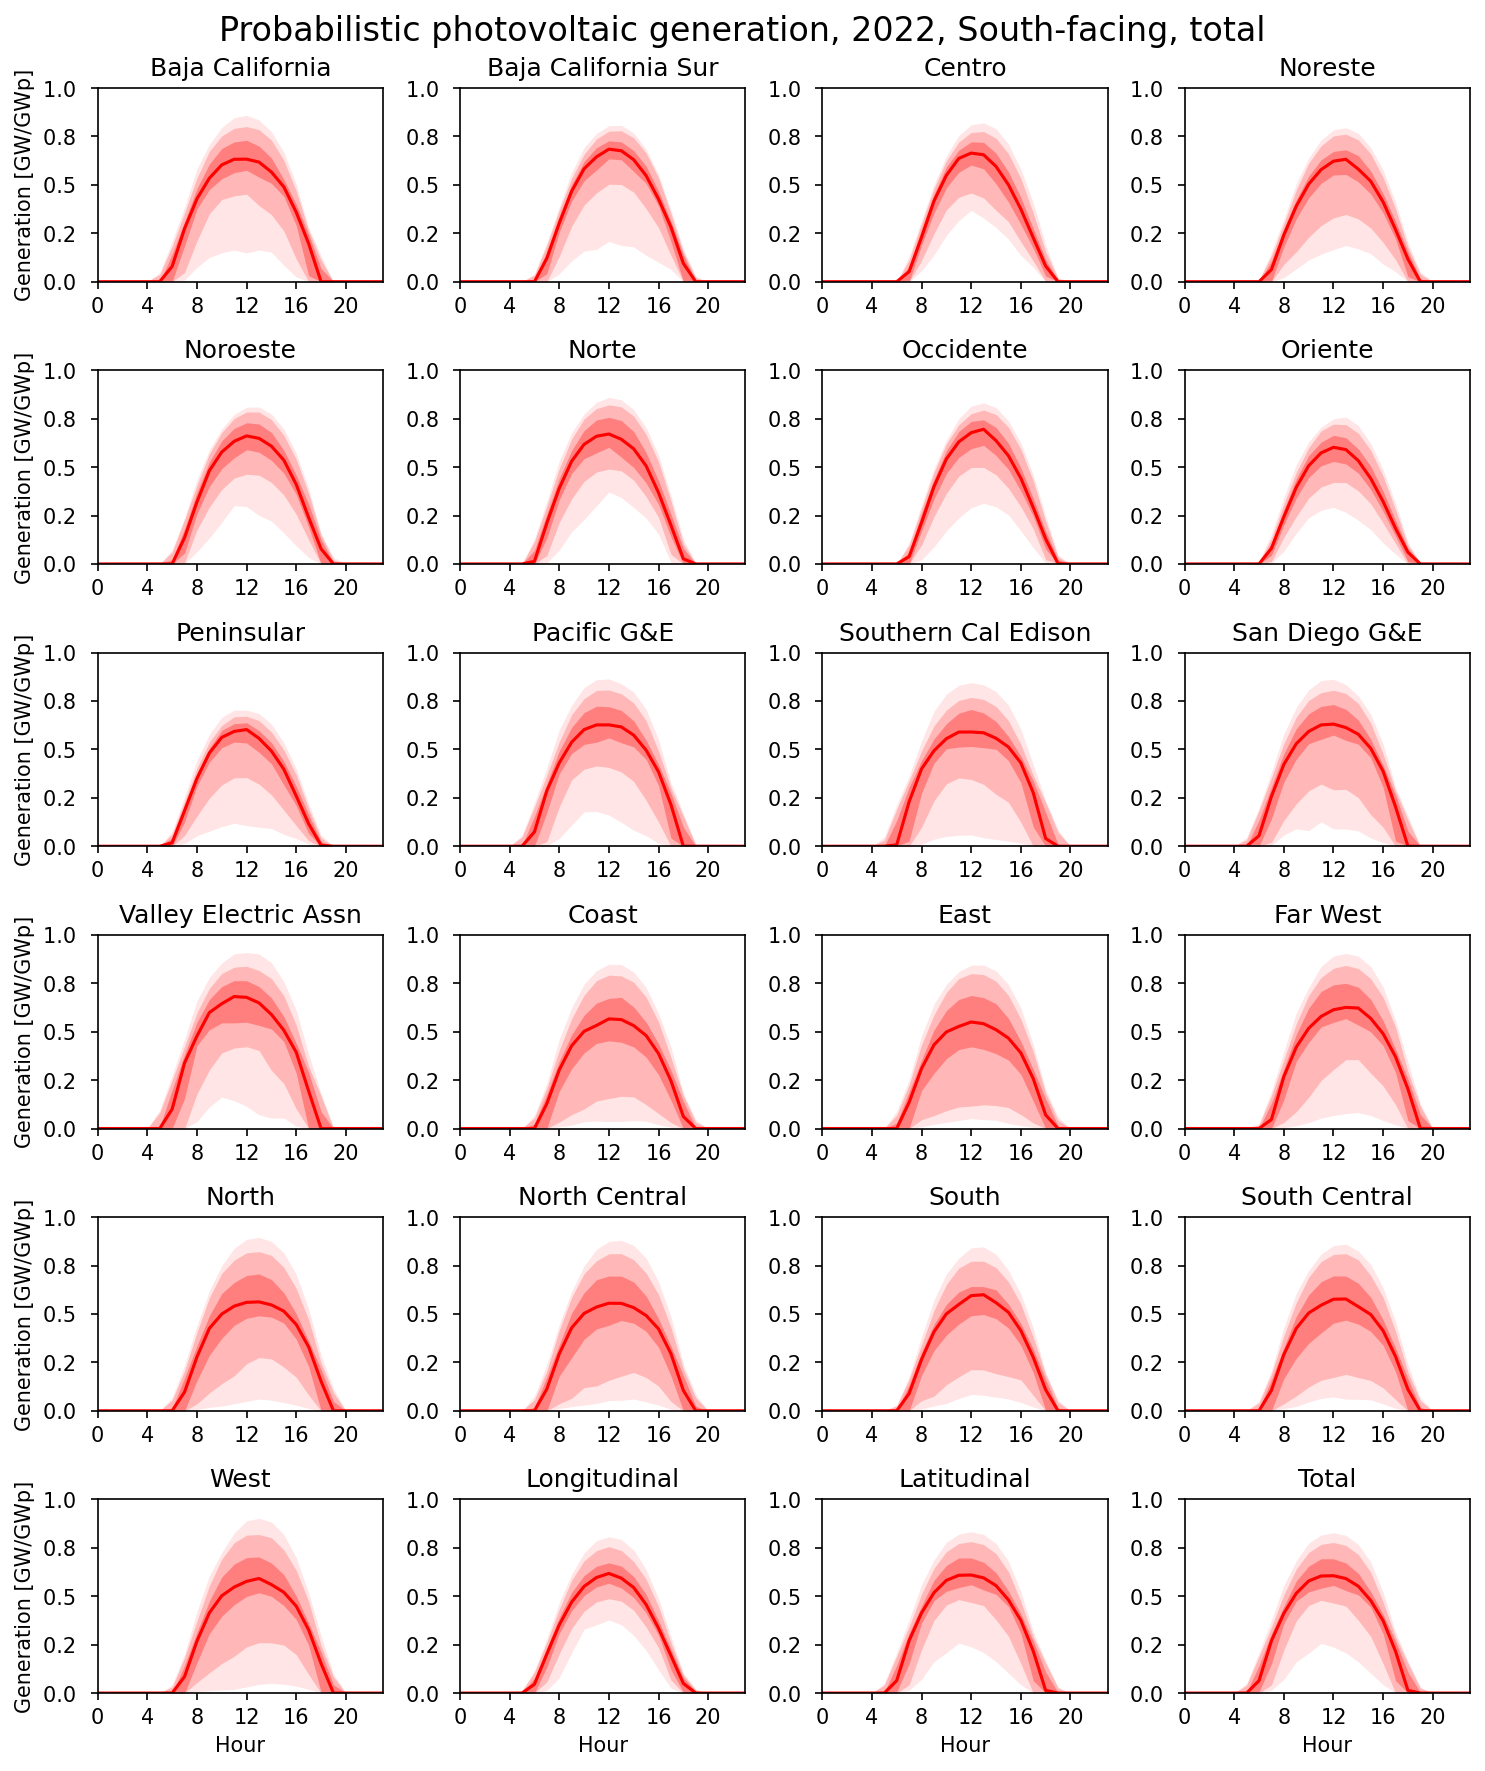

In [15]:
# Gráfica de demanda total

# Incializamos gráfica
fig, axes = plt.subplots(6, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 12)
fig.set_dpi(150) 

ds_c["hour"] = ds_c["time"].dt.hour.copy()
ds_c["dayofyear"] = ds_c["time"].dt.dayofyear.copy()

n = -8
for i, c in enumerate( ds_c["REGION"].values ):
    reg = NAME_REGION_r(c)
    df = ds_c.sel({"REGION": c}).drop_vars("REGION").to_dataframe()
    if c in [22, 23, 24]: df = df[df.index.dayofyear.isin(range(2, 365))]

    # Procesamos datos
    a = df[ ["hour", "dayofyear", prod_n_i[n]]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = prod_n_i[n] )
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1 ).T

    # Graficamos
    axes[i].fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    #axes[i].fill_between(b.index, b[0.995], b[0.005],
    #  color = "red", alpha = 0.1, linewidth = 0)
    axes[i].fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    axes[i].fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    axes[i].plot(b.index, b[0.5], color = "red")
    #axes[i].plot( a.index,
    #   a[a.min().sort_values().index[0]], color = "darkred" )

    # Formato de gráfica
    #axes[i].legend( ["Minimum-maximum envelope", "5-95% percentile",
    #    "25-75% percentile", "Median", "Day with minimum demand"] )
    axes[i].set_xlim(0, 23)
    axes[i].set_ylim(0, 1)
    axes[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    axes[i].yaxis.set_major_formatter(StrMethodFormatter("{x:<4.1f}"))
    if i%4 == 0: axes[i].set_ylabel("Generation [GW/GWp]")
    axes[i].set_title(reg)

# Formato de toda la gráfica
for i in [-4, -3, -2, -1]: axes[i].set_xlabel("Hour")
fig.suptitle(f"Probabilistic photovoltaic generation, 2022, "
    + f"{names_dn[n%8]}, {prod_n_i[n].split("_")[-1]}", fontsize = 16)
fig.tight_layout()
plt.show()

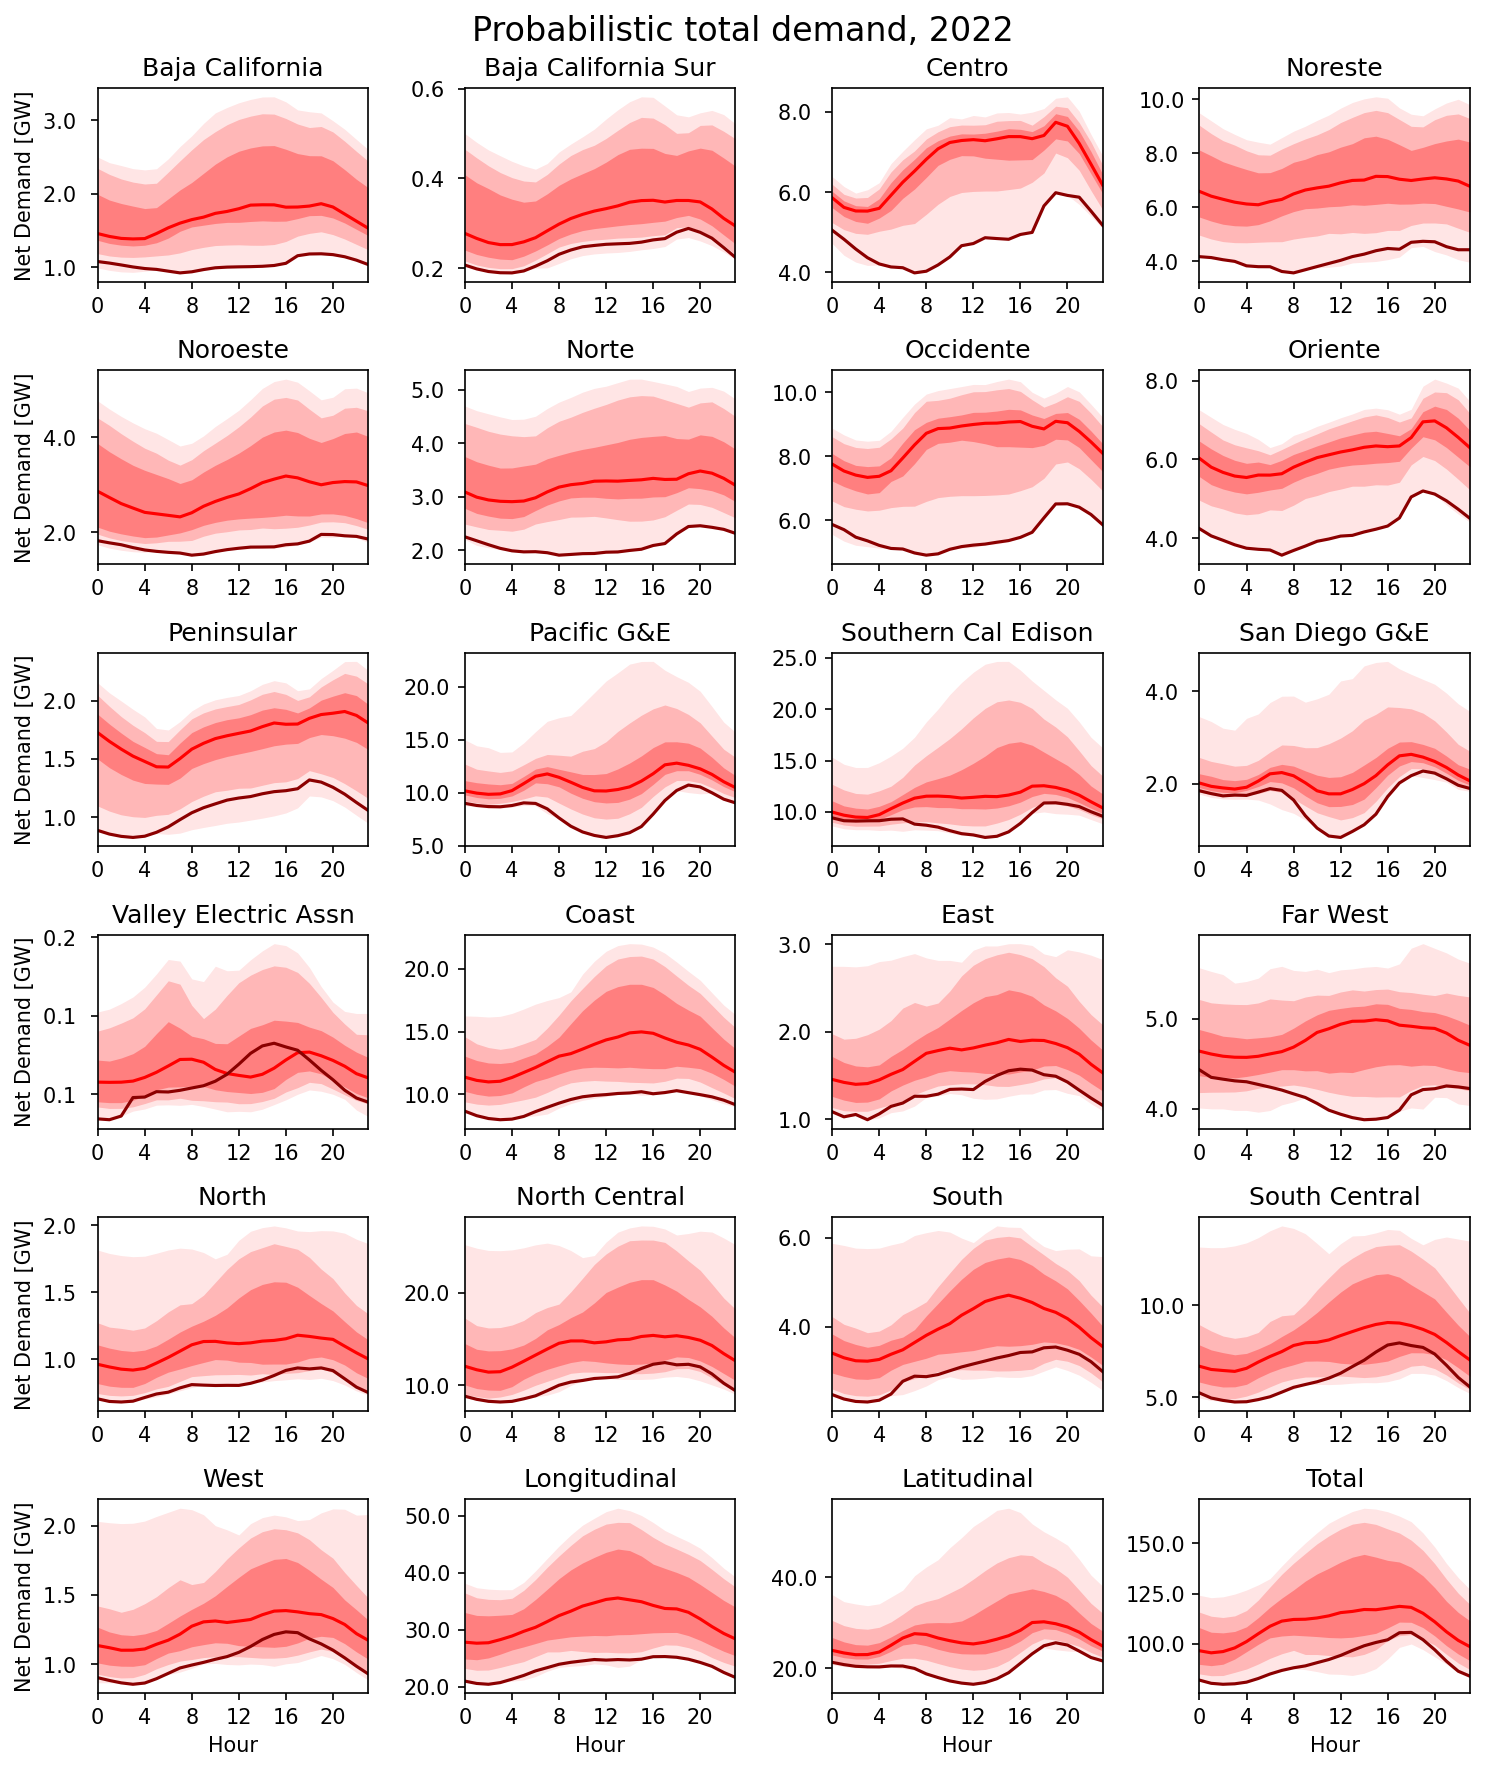

In [16]:
# Gráfica de demanda total

# Incializamos gráfica
fig, axes = plt.subplots(6, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 12)
fig.set_dpi(150) 

for i, c in enumerate( ds_d["REGION"].values ):
    reg = NAME_REGION_r(c)
    df = ds_d.sel({"REGION": c}).drop_vars("REGION").to_dataframe()
    if c in [22, 23, 24]: df = df[df.index.dayofyear.isin(range(2, 365))]

    # Procesamos datos
    a = df[ ["hour", "dayofyear", "Demand"]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = "Demand" ) / 1000
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1 ).T

    # Graficamos
    axes[i].fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    #axes[i].fill_between(b.index, b[0.995], b[0.005],
    #  color = "red", alpha = 0.1, linewidth = 0)
    axes[i].fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    axes[i].fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    axes[i].plot(b.index, b[0.5], color = "red")
    axes[i].plot( a.index,
       a[a.min().sort_values().index[0]], color = "darkred" )

    # Formato de gráfica
    #axes[i].legend( ["Minimum-maximum envelope", "5-95% percentile",
    #    "25-75% percentile", "Median", "Day with minimum demand"] )
    axes[i].set_xlim(0, 23)
    #axes[i].set_ylim(0, 20000)
    axes[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    axes[i].yaxis.set_major_formatter(StrMethodFormatter("{x:<4.1f}"))
    if i%4 == 0: axes[i].set_ylabel("Net Demand [GW]")
    axes[i].set_title(reg)

# Formato de toda la gráfica
for i in [-4, -3, -2, -1]: axes[i].set_xlabel("Hour")
fig.suptitle(f"Probabilistic total demand, 2022",
    fontsize = 16)
fig.tight_layout()
plt.show()

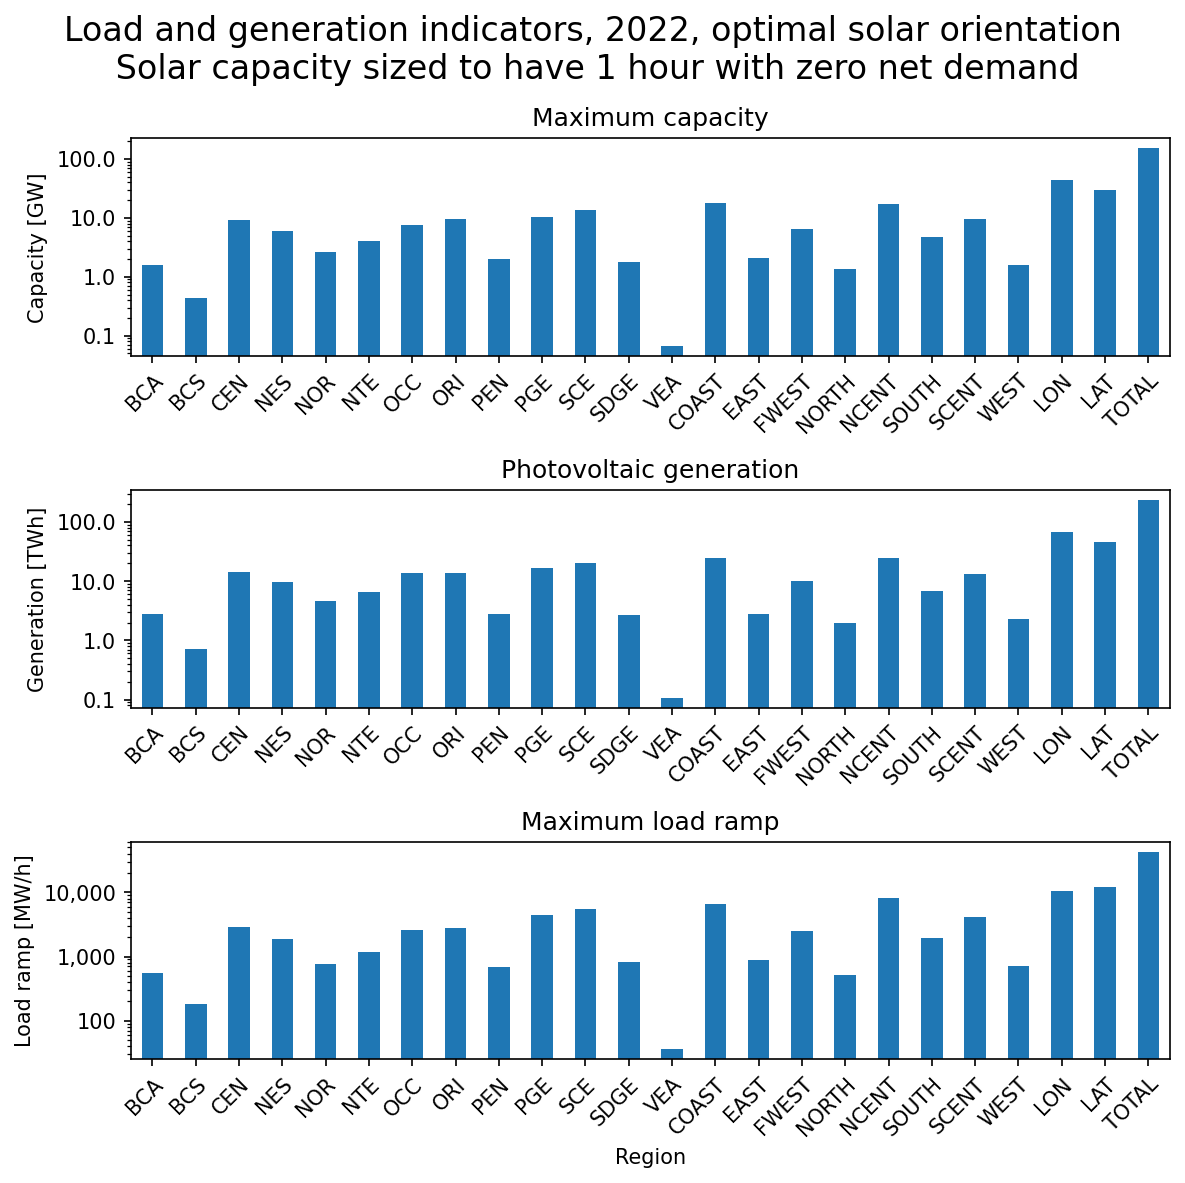

In [17]:
# Comparamos cada variable para las distintas regiones

# Escogemos la configuración ideal para cada región
conf_i = max_score.apply(lambda x: names_dn.index(x))

# Incializamos gráfica
fig, axes = plt.subplots(3)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Maximum capacity
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_cap[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[0], legend = False )
axes[0].set_title("Maximum capacity")
axes[0].set_xlabel("")
axes[0].set_ylabel("Capacity [GW]")
axes[0].set_yscale("log")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 45,
    ha = "right", rotation_mode = "anchor")
axes[0].yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))

# Photovoltaic generation
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, ener[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[1], legend = False )
axes[1].set_title("Photovoltaic generation")
axes[1].set_xlabel("")
axes[1].set_ylabel("Generation [TWh]")
axes[1].set_yscale("log")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = 45,
    ha = "right", rotation_mode = "anchor")
axes[1].yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))

# Maximum load ramp
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values: df_r_2.loc[c] = df_r.loc[
    c, track_net_demand_dt_max[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[2], legend = False )
axes[2].set_title("Maximum load ramp")
axes[2].set_xlabel("Region")
axes[2].set_ylabel("Load ramp [MW/h]")
axes[2].set_yscale("log")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation = 45,
    ha = "right", rotation_mode = "anchor")
axes[2].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

# Formato de toda la gráfica
fig.suptitle("Load and generation indicators, 2022, optimal solar orientation"
    + "\n Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

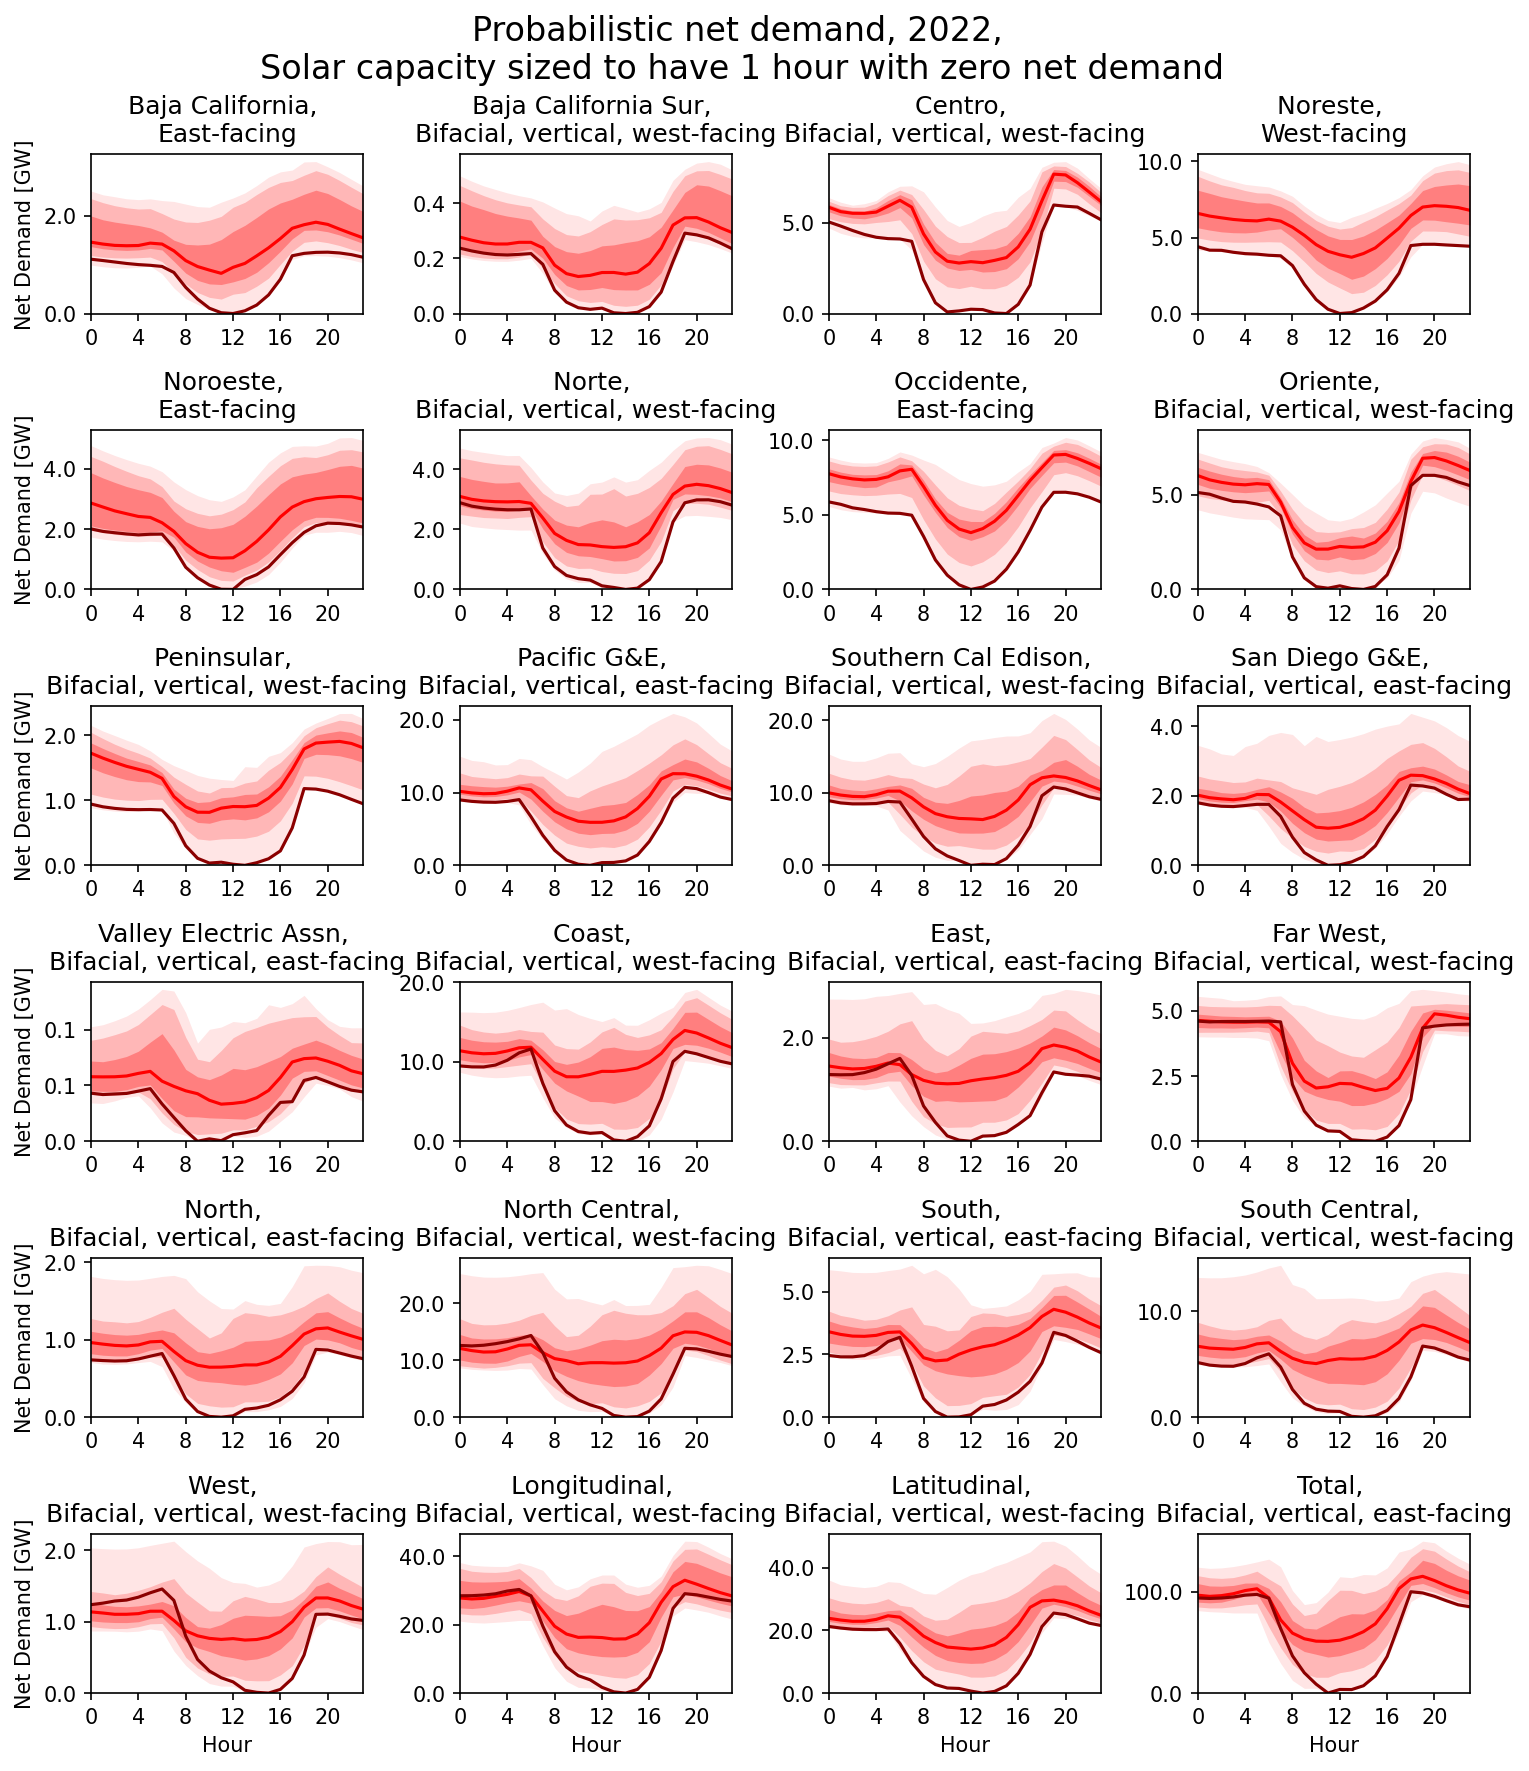

In [18]:
# Gráfica de demanda neta

# Incializamos gráfica
fig, axes = plt.subplots(6, 4)
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(10, 12)
fig.set_dpi(150) 

n = 24
# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos datos
    c = ds_c["REGION"].values[i]
    a = ds_c.sel({"REGION": c}).drop_vars("REGION")[ [ "hour", "dayofyear",
        track_net_demand[n + conf_i[c]] ] ].to_dataframe()
    a[track_net_demand[n + conf_i[c]]] /= 1000
    a = a.reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = track_net_demand[n + conf_i[c]] )
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1) .T

    # Graficamos
    ax.fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    #ax.fill_between(b.index, b[0.995], b[0.005],
    #    color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")
    ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

    ax.set_title(f"{NAME_REGION_r(c)}, \n{names_dn[conf_i[c]]}")
    ax.set_xlim(0, 23)
    ax.set_ylim(0)
    #ax.set_ylim(0, 10000)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
    if i%4 == 0: ax.set_ylabel("Net Demand [GW]")
    if len(axes) - i <= 4: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle(f"Probabilistic net demand, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

# Resumen por región

In [123]:
# Escogemos los datos de una región
c = 8
reg = NAME_REGION_r(c)
df = ds_c.sel({"REGION": c}).drop_vars("REGION").to_dataframe()

# Resultados de producción fotovoltaica
pd.options.display.float_format = "{:,.0f} GWh/GWp".format

# Non-weighted
print(f"Photovoltaic generation, non-weighted, {reg}")
a = df[prod_n_sum].iloc[0]
a.index = prod_n
print(a.sort_values(ascending = False).to_string())

# Distributed
print()
print(f"Photovoltaic generation, distributed, {reg}")
a = df[prod_n_dist_sum].iloc[0]
a.index = prod_n
print(a.sort_values(ascending = False).to_string())

# Solar parks
print()
print(f"Photovoltaic generation, solar parks, {reg}")
a = df[prod_n_centr_sum].iloc[0]
a.index = prod_n
print(a.sort_values(ascending = False).to_string())

# Photovoltaic generation
print()
print(f"Photovoltaic generation, total, {reg}")
a = df[prod_n_total_sum].iloc[0]
a.index = prod_n
print(a.sort_values(ascending = False).to_string())


Photovoltaic generation, non-weighted, Oriente
2_track_P_mp                  1,984 GWh/GWp
1_track_P_mp                  1,873 GWh/GWp
bifacial_south_P_mp           1,769 GWh/GWp
south_no_track_P_mp           1,610 GWh/GWp
east_no_track_P_mp            1,530 GWh/GWp
west_no_track_P_mp            1,493 GWh/GWp
bifacial_vertical_east_P_mp   1,226 GWh/GWp
bifacial_vertical_west_P_mp   1,205 GWh/GWp

Photovoltaic generation, distributed, Oriente
south_no_track_P_mp           1,645 GWh/GWp
west_no_track_P_mp            1,645 GWh/GWp
east_no_track_P_mp            1,645 GWh/GWp
1_track_P_mp                  1,645 GWh/GWp
2_track_P_mp                  1,645 GWh/GWp
bifacial_vertical_west_P_mp   1,645 GWh/GWp
bifacial_vertical_east_P_mp   1,645 GWh/GWp
bifacial_south_P_mp           1,645 GWh/GWp

Photovoltaic generation, solar parks, Oriente
2_track_P_mp                  1,989 GWh/GWp
1_track_P_mp                  1,878 GWh/GWp
bifacial_south_P_mp           1,774 GWh/GWp
south_no_track_P_mp    

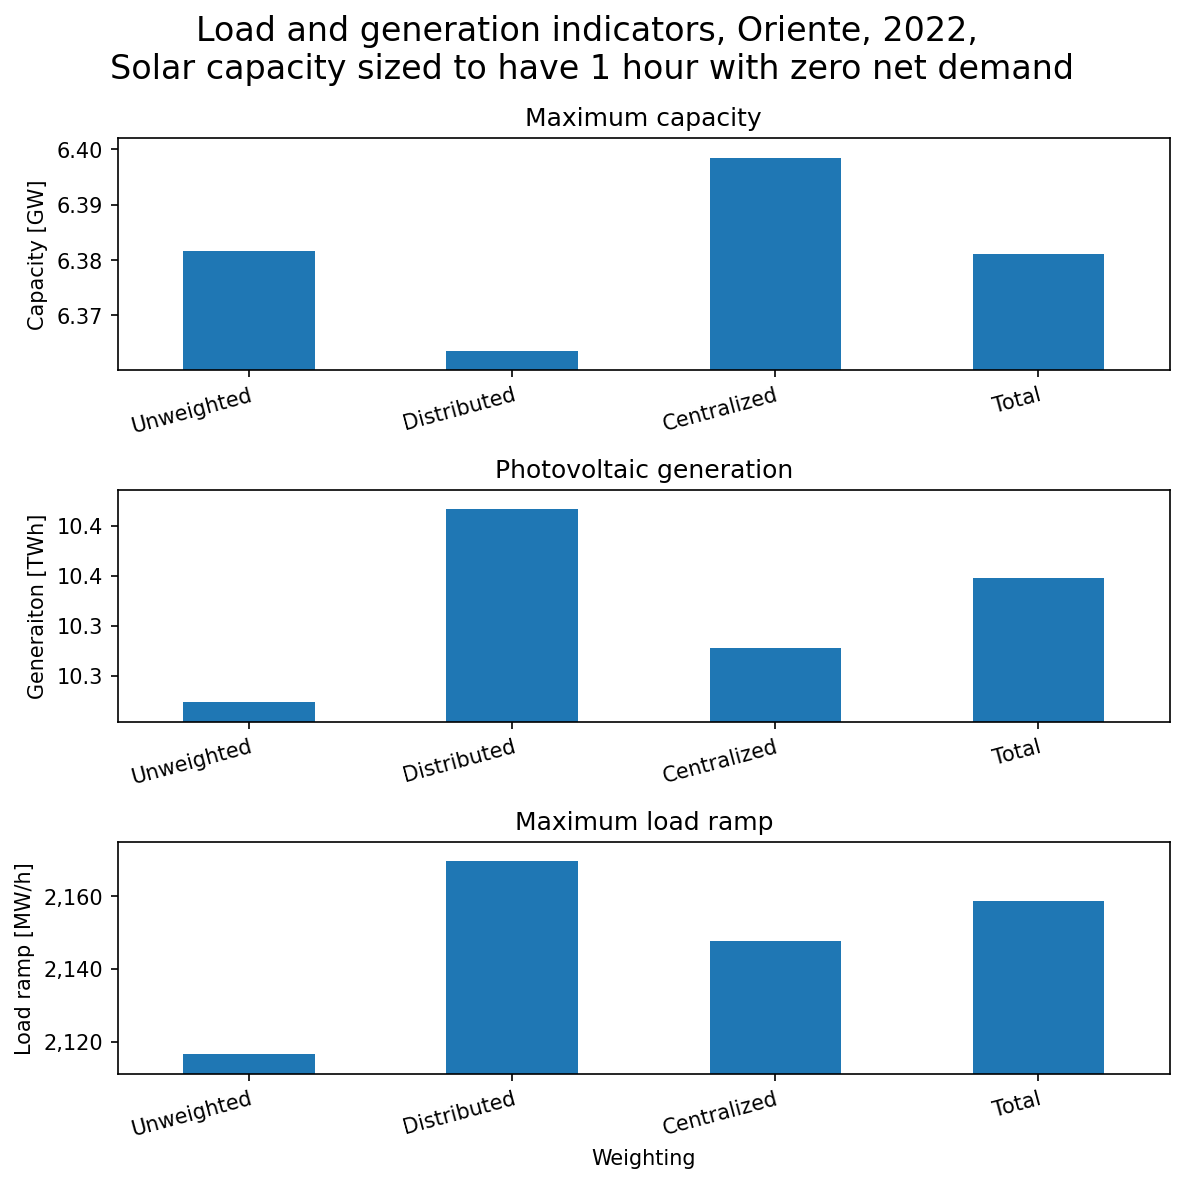

In [124]:
# Comparamos cada variable para los distintos tipos de producción solar

# Incializamos gráfica
fig, axes = plt.subplots(3)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

n = 0
# Maximum capacity
data = df[prod_n_cap[n::8]].iloc[0]
data.plot.bar( ax = axes[0] )
axes[0].set_title("Maximum capacity")
axes[0].set_xlabel("")
axes[0].set_ylabel("Capacity [GW]")
axes[0].yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}"))
axes[0].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
axes[0].set_ylim(data.min()*1.1 - data.max()*0.1,
    data.max()*1.1 - data.min()*0.1)

# Photovoltaic generation
data = df[ener[n::8]].iloc[0]
data.plot.bar( ax = axes[1] )
axes[1].set_title("Photovoltaic generation")
axes[1].set_xlabel("")
axes[1].set_ylabel("Generaiton [TWh]")
axes[1].yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
axes[1].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
axes[1].set_ylim(data.min()*1.1 - data.max()*0.1,
    data.max()*1.1 - data.min()*0.1)

# "Maximum load ramp"
data =  df[track_net_demand_dt_max[n+1::8]].iloc[0]
data.plot.bar( ax = axes[2] )
axes[2].set_title("Maximum load ramp")
axes[2].set_xlabel("Weighting")
axes[2].set_ylabel("Load ramp [MW/h]")
axes[2].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[2].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
axes[2].set_ylim(data.min()*1.1 - data.max()*0.1,
    data.max()*1.1 - data.min()*0.1)

# Formato de toda la gráfica
fig.suptitle(f"Load and generation indicators, {reg}, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_19981/3646957009.py:35: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "5-95% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_19981/3646957009.py:38: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "_", "25-75% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_19981/3646957009.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an unders

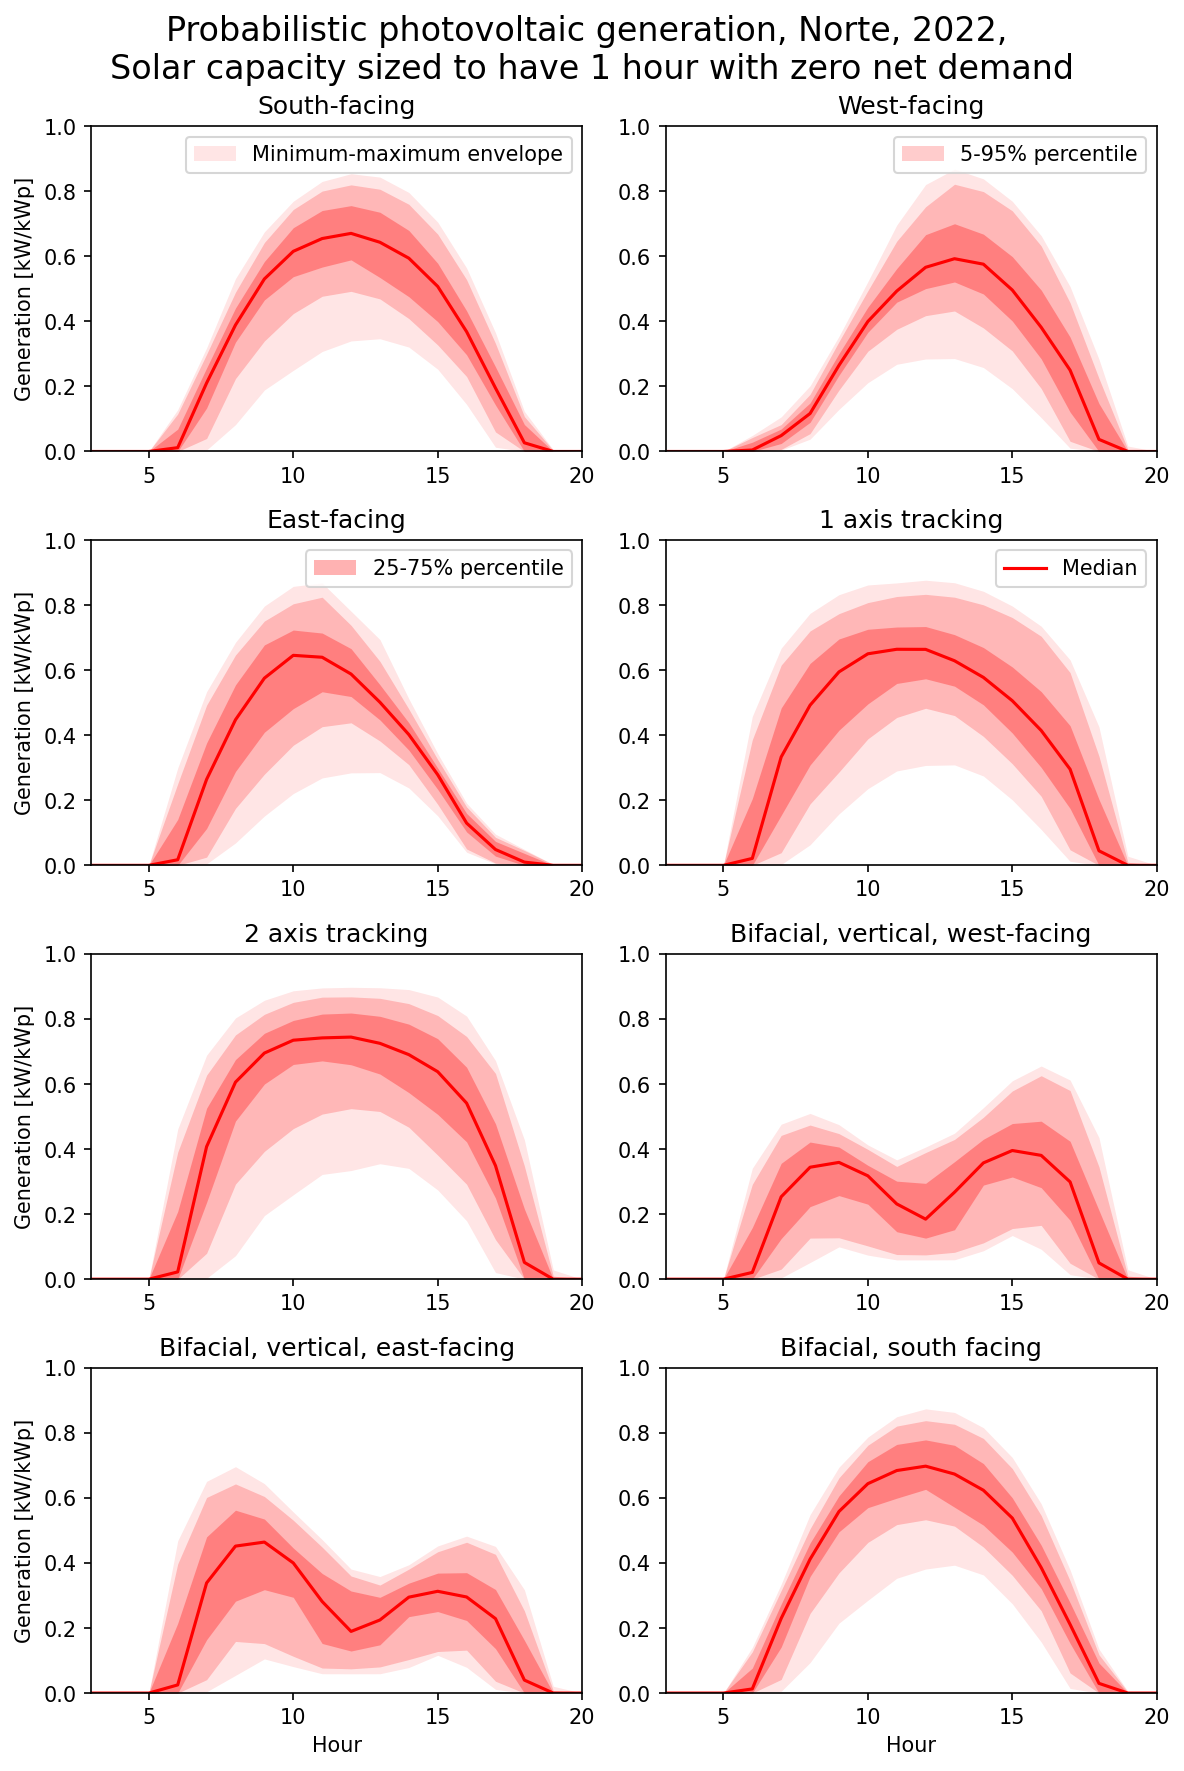

In [78]:
# Gráfica de producción fotovoltaica

# Incializamos gráfica
fig, axes = plt.subplots(4, 2)
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(8, 12)
fig.set_dpi(150) 

# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos los datos
    a = df[ ["hour", "dayofyear", prod_n[i]]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = prod_n[i] )
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1 ).T

    # Graficamos
    ax.fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    #ax.fill_between(b.index, b[0.995], b[0.005],
    #    color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")

    # Formato de gráfica
    if   i == 0:
        ax.legend( ["Minimum-maximum envelope"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 1:
        ax.legend( ["_", "5-95% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 2:
        ax.legend( ["_", "_", "25-75% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 3:
        ax.legend( ["_", "_", "_", "Median"],
            prop = { "size": 10 }, ncol = 2 )
    ax.set_title(names_dn[i])
    ax.set_xlim(3, 20)
    ax.set_ylim(0, 1)
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
    if i%2 == 0: ax.set_ylabel("Generation [kW/kWp]")
    if len(axes) - i <= 2: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle(f"Probabilistic photovoltaic generation, {reg}, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

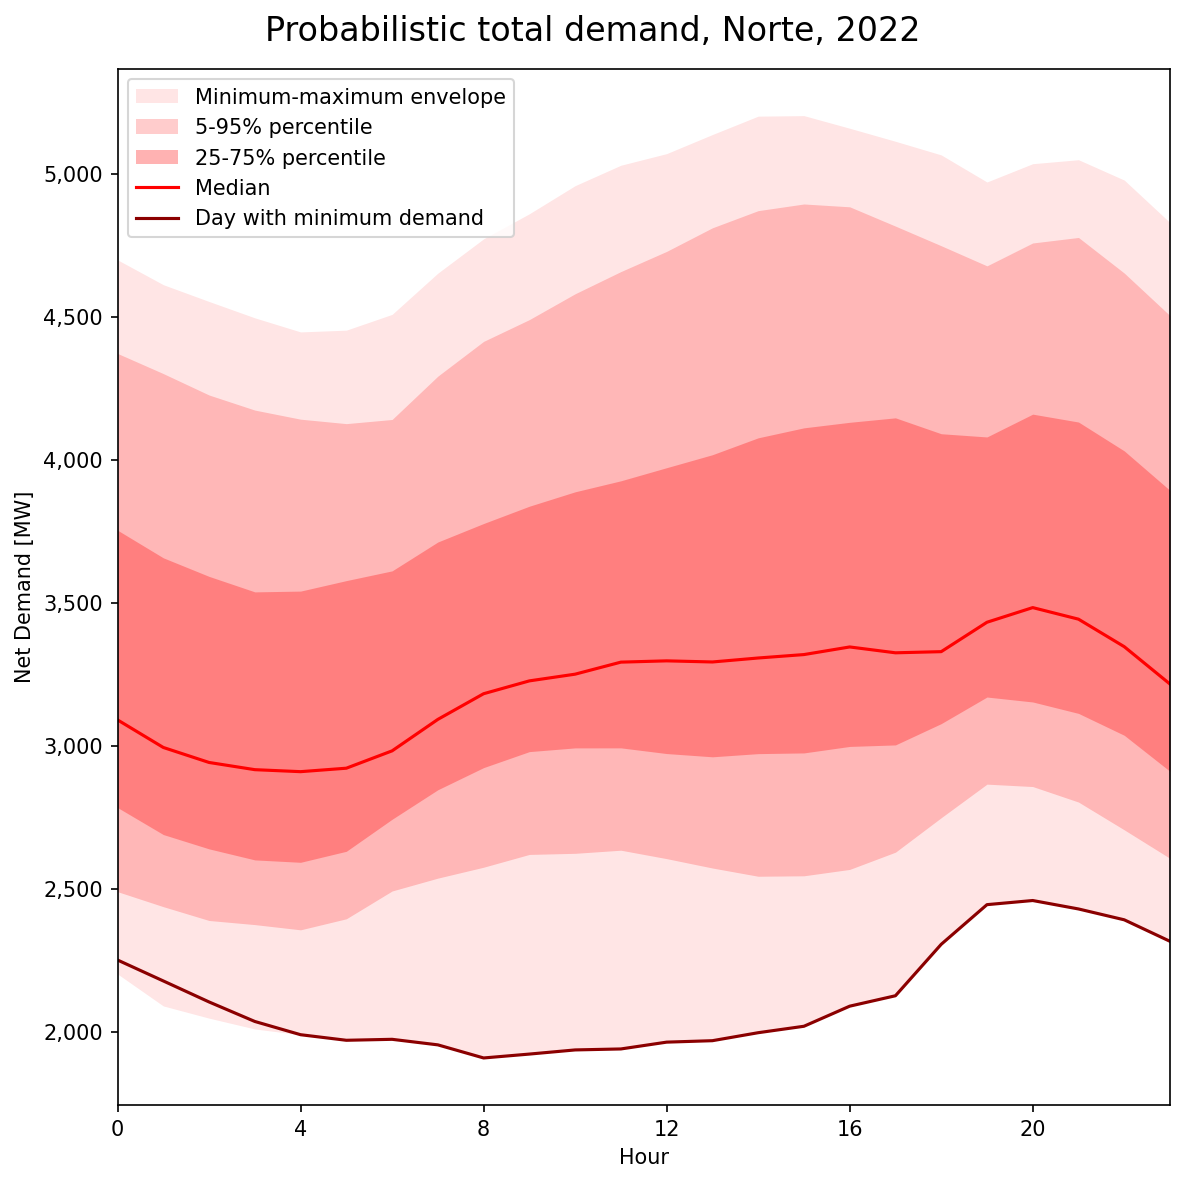

In [79]:
# Gráfica de demanda total

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Procesamos datos
a = df[ ["hour", "dayofyear", "Demand"]
    ].reset_index(drop = True).pivot( index = "hour",
    columns = "dayofyear", values = "Demand" )
if c in [22, 23, 24]: a = a.drop(columns = [1, 365])
b = a.quantile([0, 0.005, 0.05, 0.25, 0.5, 0.75, 0.95, 0.995, 1], axis = 1).T

# Graficamos
ax.fill_between(b.index, b[1], b[0],
    color = "red", alpha = 0.1, linewidth = 0)
#ax.fill_between(b.index, b[0.995], b[0.005],
#    color = "red", alpha = 0.1, linewidth = 0)
ax.fill_between(b.index, b[0.95], b[0.05],
    color = "red", alpha = 0.2, linewidth = 0)
ax.fill_between(b.index, b[0.75], b[0.25],
    color = "red", alpha = 0.3, linewidth = 0)
ax.plot(b.index, b[0.5], color = "red")
ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

# Formato de gráfica
ax.legend( ["Minimum-maximum envelope", "5-95% percentile",
    "25-75% percentile", "Median",
    "Day with minimum demand"], loc = "upper left" )
ax.set_xlim(0, 23)
#ax.set_ylim(3500, 8500)
ax.xaxis.set_major_locator(plt.MultipleLocator(4))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("Net Demand [MW]")
ax.set_xlabel("Hour")
fig.suptitle(f"Probabilistic total demand, {reg}, 2022",
    fontsize = 16)
fig.tight_layout()
plt.show()

In [80]:
# Resultados para cada configuración
results = [ prod_n_sum_i[-8:], prod_n_cap[-8:], ener[-8:], cap_f[-8:],
     track_net_demand_max[-8:], track_net_demand_dt_max[-8:] ]
indicators = [ "Photovoltaic production per kWp", "Maximum capacity",
    "Photovoltaic production", "Capacity factor",
    "Maximum load", "Maximum load ramp" ]
format = [ "{:,.0f} kWh/kWp".format, "{:.1f} GW".format,
           "{:,.0f} TWh".format, "{:.1f} %".format,
           "{:,.0f} MW".format, "{:,.0f} MW".format]

for i in range(len(results)):
    print(indicators[i])
    pd.options.display.float_format = format[i]
    a = df[results[i]].iloc[i]
    a.index = names_dn
    print( a.sort_values(ascending = False).to_string() )
    print()

Photovoltaic production per kWp
2 axis tracking                   2,254 kWh/kWp
1 axis tracking                   2,086 kWh/kWp
Bifacial, south facing            2,021 kWh/kWp
South-facing                      1,969 kWh/kWp
East-facing                       1,809 kWh/kWp
West-facing                       1,787 kWh/kWp
Bifacial, vertical, east-facing   1,632 kWh/kWp
Bifacial, vertical, west-facing   1,624 kWh/kWp

Maximum capacity
Bifacial, vertical, west-facing   4.1 GW
Bifacial, vertical, east-facing   4.0 GW
East-facing                       3.2 GW
West-facing                       3.1 GW
1 axis tracking                   3.1 GW
South-facing                      2.6 GW
Bifacial, south facing            2.6 GW
2 axis tracking                   2.5 GW

Photovoltaic production
Bifacial, vertical, west-facing   7 TWh
Bifacial, vertical, east-facing   7 TWh
1 axis tracking                   6 TWh
East-facing                       6 TWh
2 axis tracking                   6 TWh
West-facing  

TypeError: Legend.__init__() got an unexpected keyword argument 'oc'

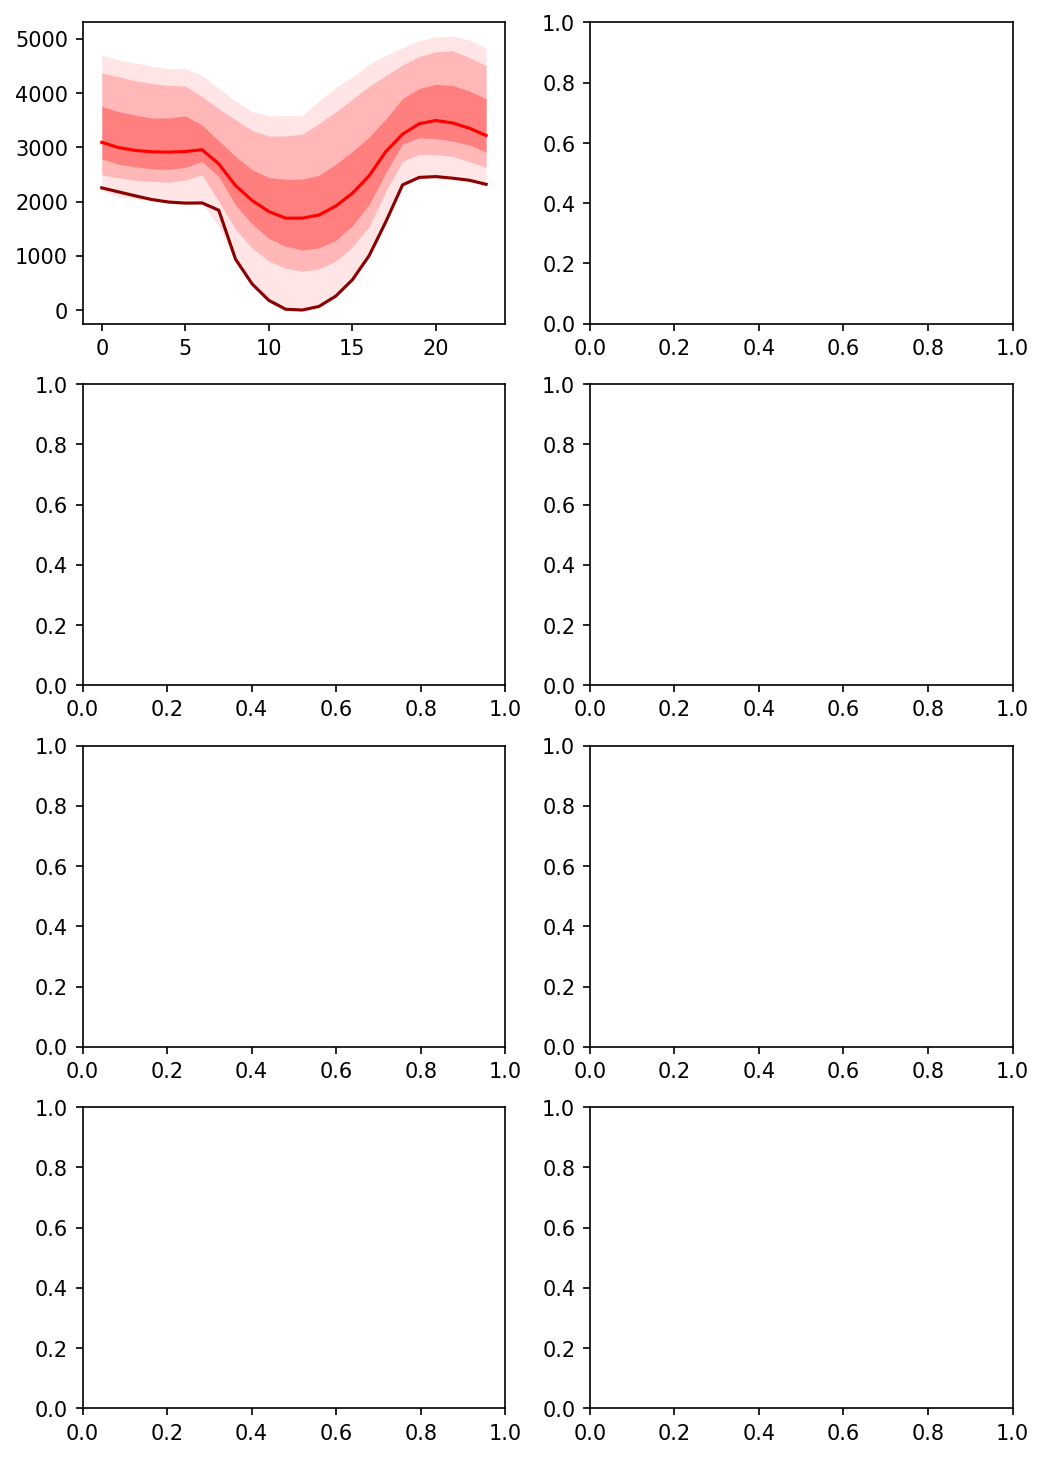

In [81]:
# Gráfica de demanda neta

# Incializamos gráfica
fig, axes = plt.subplots(4, 2)
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(8, 12)
fig.set_dpi(150) 

# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos datos
    a = df[ ["hour", "dayofyear", track_net_demand[i]]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = track_net_demand[i] )
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1) .T

    # Graficamos
    ax.fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    #ax.fill_between(b.index, b[0.995], b[0.005],
    #    color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")
    ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

    # Formato de gráfica
    if   i == 0:
        ax.legend( ["Minimum-maximum envelope"],
             oc = "upper left", prop = { "size": 10 }, ncol = 2 )
    elif i == 1:
        ax.legend( ["_", "5-95% percentile"],
            loc = "upper left", prop = { "size": 10 }, ncol = 2 )
    elif i == 2:
        ax.legend( ["_", "_", "25-75% percentile"],
            loc = "upper left", prop = { "size": 10 }, ncol = 2 )
    elif i == 3:
        ax.legend( ["_", "_", "_", "Median"],
            loc = "upper left", prop = { "size": 10 }, ncol = 2 )
    elif i == 4:
        ax.legend( ["_", "_", "_", "_", "Day with minimum net demand"],
            loc = "upper left", prop = { "size": 10 }, ncol = 2 )
    ax.set_title(names_dn[i])
    ax.set_xlim(0, 23)
    ax.set_ylim(0)
    #ax.set_ylim(0, 10000)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    if i%2 == 0: ax.set_ylabel("Net Demand [MW]")
    if len(axes) - i <= 2: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle(f"Probabilistic net demand, {reg}, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

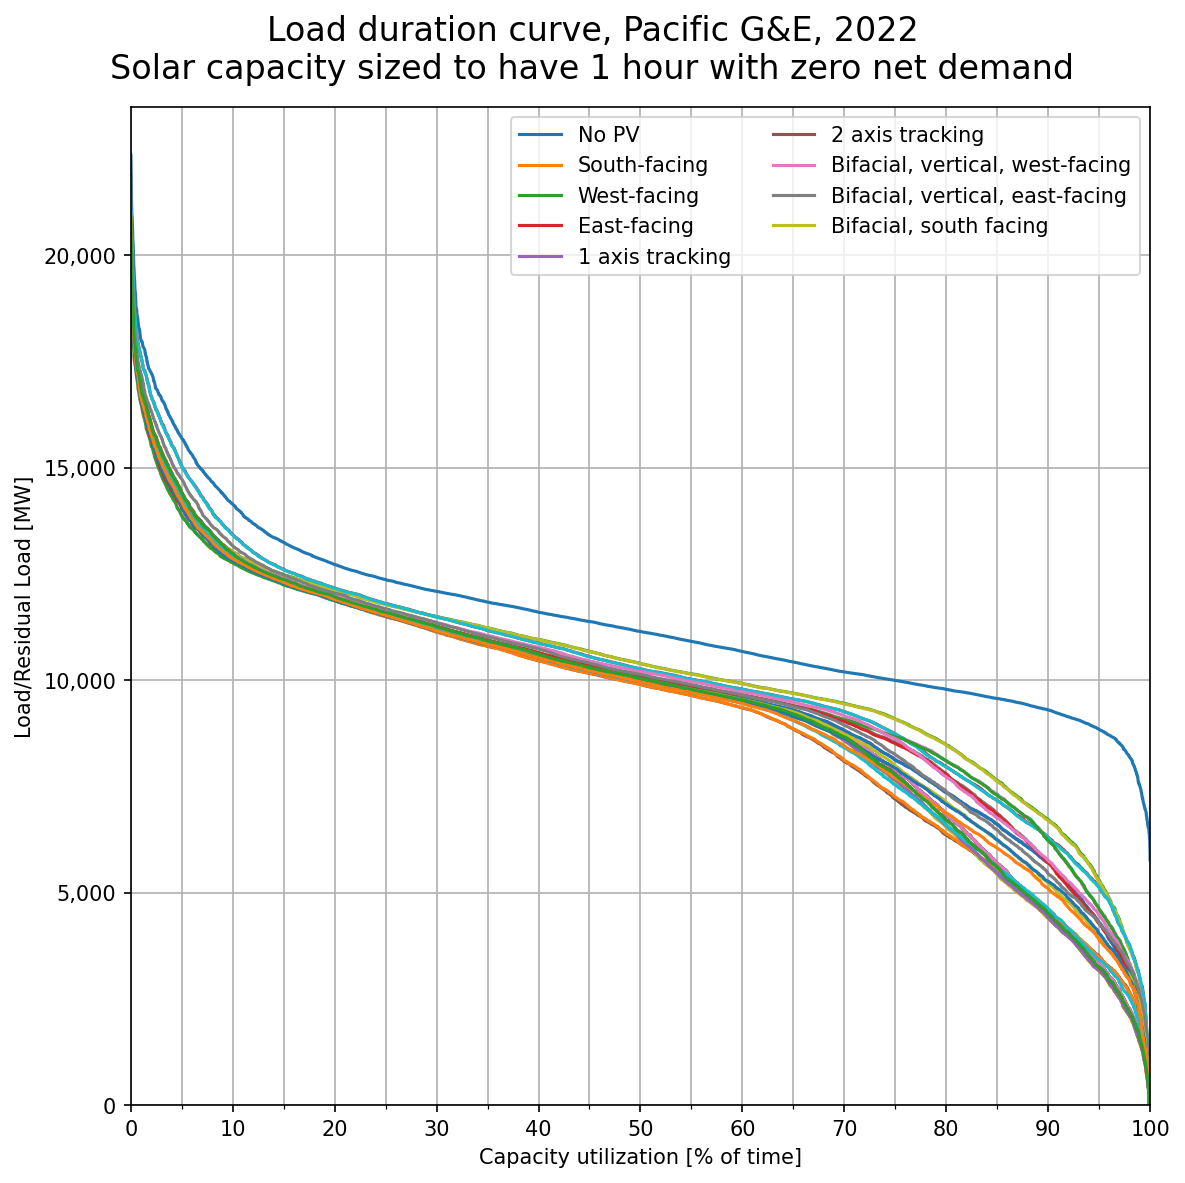

In [ ]:
# Load duration curve

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Iteramos para cada caso
for v in ["Demand"] + track_net_demand:
    a = df[ [v] ].sort_values( v, ascending = False ).reset_index(drop = True)
    a.index /= 2
    a.index = a.index / a.index.max() * 100
    ax.plot(a.index, a[v])

# Formato de gráfica
ax.legend( ["No PV"] + names_dn, ncol = 2 )
ax.set_xlim(0, 100)
#ax.set_ylim(0, 8500)
ax.set_ylim(0)
ax.grid("both", "both")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(1000))
#ax.yaxis.set_minor_locator(plt.MultipleLocator(500))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("Load/Residual Load [MW]")
ax.set_xlabel("Capacity utilization [% of time]")
fig.suptitle(f"Load duration curve, {reg}, 2022\n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_19981/3792840233.py:26: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axes[0].legend( ["No PV"] + names_dn[:4] + ["_"]*4, ncol = 1 )
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_19981/3792840233.py:40: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axes[1].legend( ["_"]*4 + names_dn[4:], ncol = 1 )


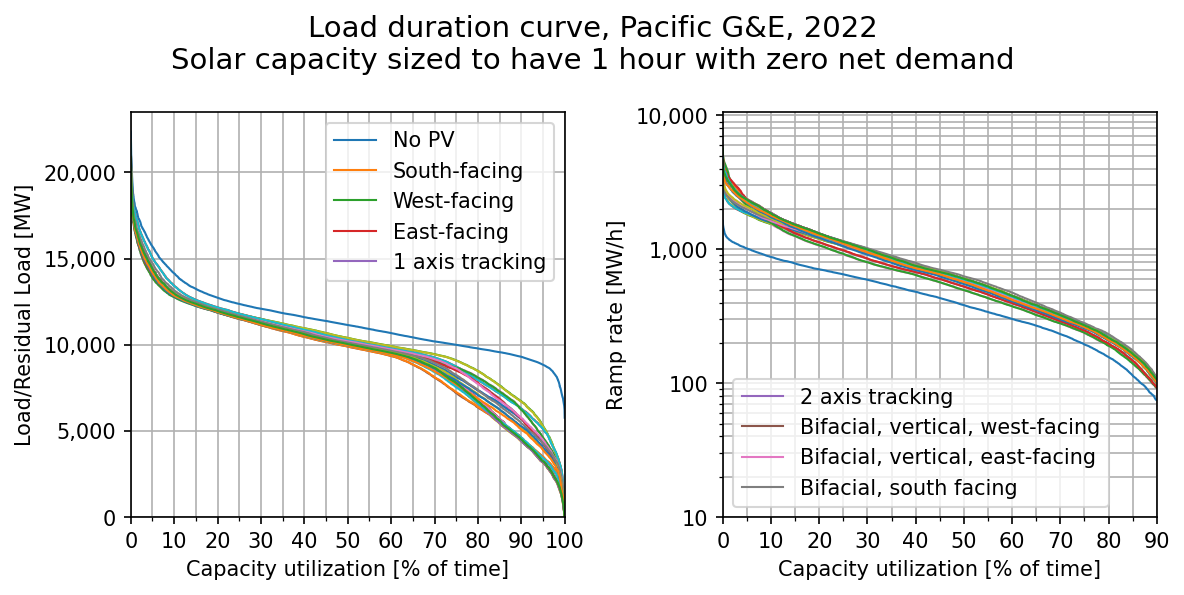

In [ ]:
# Load duration curve + ramp duration curve

# Incializamos gráfica
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150) 

# Iteramos para cada caso
for v in ["Demand"] + track_net_demand:
    a = df[ [v] ].sort_values( v, ascending = False ).reset_index(drop = True)
    a.index /= 2
    a.index = a.index / a.index.max() * 100
    axes[0].plot(a.index, a[v], linewidth = 1)

# Iteramos para cada caso
for v in ["Demand_dt"] + track_net_demand_dt:
    a = np.abs(df[[v]]).sort_values( v,
        ascending = False ).reset_index(drop = True)
    a = a.where(a>0, 0)
    a.index = a.index / a.index.max() * 100
    axes[1].plot(a.index, a[v], linewidth = 1)

# Formato de gráfica
axes[0].legend( ["No PV"] + names_dn[:4] + ["_"]*4, ncol = 1 )
axes[0].set_xlim(0, 100)
#axes[0].set_ylim(0, 8500)
axes[0].set_ylim(0)
axes[0].grid("both", "both")
axes[0].xaxis.set_major_locator(plt.MultipleLocator(10))
axes[0].xaxis.set_minor_locator(plt.MultipleLocator(5))
#axes[0].yaxis.set_major_locator(plt.MultipleLocator(1000))
#axes[0].yaxis.set_minor_locator(plt.MultipleLocator(500))
axes[0].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[0].set_ylabel("Load/Residual Load [MW]")
axes[0].set_xlabel("Capacity utilization [% of time]")

# Formato de gráfica
axes[1].legend( ["_"]*4 + names_dn[4:], ncol = 1 )
axes[1].set_yscale("log")
axes[1].set_xlim(0, 90)
axes[1].set_ylim(10)
axes[1].grid("both", "both")
axes[1].xaxis.set_major_locator(plt.MultipleLocator(10))
axes[1].xaxis.set_minor_locator(plt.MultipleLocator(5))
axes[1].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[1].set_ylabel("Ramp rate [MW/h]")
axes[1].set_xlabel("Capacity utilization [% of time]")

fig.suptitle(f"Load duration curve, {reg}, 2022\n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 14)
fig.tight_layout()
plt.show()